In [1]:
!pip install transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

In [2]:
model_name = 'bert-base-uncased'
num_labels = 3
max_length = 128
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
texts = [
    # Positive Sentences (Label 0)
    "Exports from Asia surge as demand for electronics rises globally.",
    "Banking sector shows resilience with strong capital buffers.",
    "Consumer loan growth accelerates amid low interest rates.",
    "Insurance company posts record profits from premium collections.",
    "Automobile sales rebound after festive season demand surge.",
    "Green energy adoption boosts investment in solar companies.",
    "Technology sector leads market gains with double-digit growth.",
    "Company secures long-term government defense contract.",
    "Pharma company’s vaccine rollout receives global recognition.",
    "Tourism earnings soar after record international arrivals.",
    "Foreign direct investment inflows hit a decade-high mark.",
    "Digital payments adoption grows rapidly across all sectors.",
    "Construction company wins major highway expansion project.",
    "Agriculture output exceeds forecasts, supporting rural economy.",
    "Company announces profit-sharing bonus for employees.",
    "Cloud computing revenues grow steadily each quarter.",
    "Private equity firm invests $500 million in retail expansion.",
    "Bond yields stabilize as inflation fears ease.",
    "Mergers and acquisitions activity accelerates in healthcare.",
    "New tax reforms spur corporate investment confidence.",
    "Luxury real estate market sees record-breaking sales.",
    "Air cargo volumes increase with strong e-commerce demand.",
    "Exports of agricultural commodities climb significantly.",
    "Tech stocks rally as innovation drives market optimism.",

    # Negative Sentences (Label 1)
    "Company reports significant decline in quarterly net income.",
    "Rising crude oil prices squeeze transportation sector margins.",
    "Retail footfall decreases due to sluggish consumer demand.",
    "Government investigation launched into corporate tax evasion.",
    "Currency depreciation raises import costs for manufacturers.",
    "Major strike disrupts port operations, delaying shipments.",
    "Bank faces liquidity crunch amid heavy withdrawals.",
    "Severe drought impacts agricultural output drastically.",
    "Airline posts heavy losses following increased fuel costs.",
    "Cyberattack disrupts operations of financial services firm.",
    "Heavy rains cause damage to warehouses and logistics hubs.",
    "Regulators block merger deal citing antitrust concerns.",
    "Steel industry hit hard by global demand slowdown.",
    "Bond defaults rise in emerging markets, spooking investors.",
    "Pharmaceutical company faces backlash over drug pricing.",
    "Electronics exports fall sharply due to weaker overseas demand.",
    "Unemployment rises as companies announce hiring freezes.",
    "Housing sector slowdown drags overall GDP growth lower.",
    "Debt-laden firm defaults on interest payments.",
    "Commodity prices slump, hitting producer profits.",
    "Air pollution fines imposed on major industrial firms.",
    "Major oil spill damages company reputation globally.",
    "Stock market volatility increases amid global uncertainties.",
    "IT firm misses deadlines, leading to client losses.",

    # Neutral Sentences (Label 2)
    "Company schedules quarterly earnings announcement for April.",
    "The financial year will conclude at the end of March.",
    "Stock exchange introduces new trading hours effective Monday.",
    "Corporate governance report was filed with the regulator.",
    "Meeting minutes from last quarter were officially published.",
    "The firm is participating in this year’s trade exhibition.",
    "A minor change in board composition was noted this week.",
    "Annual financial disclosures are due by the end of June.",
    "Government announces date for presenting economic survey.",
    "Industry-wide training seminar is scheduled next weekend.",
    "The company will hold its investor day virtually this year.",
    "A memorandum was circulated regarding internal compliance.",
    "Routine filing submitted with securities commission today.",
    "Dividend payment date confirmed for shareholders next month.",
    "Financial statements prepared according to new accounting norms.",
    "New company website launch scheduled for later this quarter.",
    "Market holidays have been announced for the fiscal year.",
    "Minutes of audit committee meeting recorded last Friday.",
    "Investor presentation materials will be uploaded online.",
    "Public consultation invited on draft financial guidelines.",
    "Securities regulator issues updated compliance checklist.",
    "New branch office inauguration is planned in the capital.",
    "Standard operating procedure updates distributed internally.",
    "Company announces date for its half-yearly board meeting."
]

labels = (
    [0]*24 +  # Positive
    [1]*24 +  # Negative
    [2]*24    # Neutral
)

df2 = pd.DataFrame({'text': texts, 'label': labels})
print(f"Dataset size: {len(df2)}")


Dataset size: 72


In [4]:
label_counts = df2['label'].value_counts().sort_index()
print("Label distribution:")
print(f"Positive (0): {label_counts[0]}")
print(f"Negative (1): {label_counts[1]}")
print(f"Neutral (2): {label_counts[2]}")

Label distribution:
Positive (0): 24
Negative (1): 24
Neutral (2): 24


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    df2['text'].values,
    df2['label'].values,
    test_size=0.2,
    random_state=seed,
    stratify=df2['label'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 57
Validation samples: 15


In [6]:
tokenizer = BertTokenizer.from_pretrained(model_name)
print(f"Tokenizer loaded")
print(f"Vocabulary size: {tokenizer.vocab_size}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded
Vocabulary size: 30522


In [7]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined")

Dataset class defined


In [8]:
train_dataset = FinancialDataset(X_train, y_train, tokenizer, max_length)
val_dataset = FinancialDataset(X_val, y_val, tokenizer, max_length)

print(f"Train dataset created: {len(train_dataset)} samples")
print(f"Validation dataset created: {len(val_dataset)} samples")

Train dataset created: 57 samples
Validation dataset created: 15 samples


In [9]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print("BERT model loaded")
print(f"Model type: {model_name}")
print(f"Number of labels: {num_labels}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded
Model type: bert-base-uncased
Number of labels: 3


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    seed=seed,
    report_to="none"
)

print("Training arguments set")

Training arguments set


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

print("Trainer created")

print("Starting training...")
print("-" * 50)

train_result = trainer.train()

print("Training completed!")

Trainer created
Starting training...
--------------------------------------------------


Epoch,Training Loss,Validation Loss
1,No log,1.129183
2,No log,1.127370
3,1.113500,1.124400


Training completed!


In [12]:
train_loss = train_result.metrics['train_loss']
print(f"Final training loss: {train_loss:.4f}")

print("Evaluating on validation set...")

eval_results = trainer.evaluate()

print("Evaluation results:")
print(f"Validation loss: {eval_results['eval_loss']:.4f}")

Final training loss: 1.1188
Evaluating on validation set...


Evaluation results:
Validation loss: 1.1244


In [13]:
print("Getting predictions...")
predictions = trainer.predict(val_dataset)
predicted_probs = predictions.predictions
predicted_classes = np.argmax(predicted_probs, axis=1)
true_labels = predictions.label_ids
print(f"Predictions shape: {predicted_classes.shape}")
print(f"True labels shape: {true_labels.shape}")

Getting predictions...


Predictions shape: (15,)
True labels shape: (15,)


In [14]:
correct_predictions = 0
total_predictions = len(predicted_classes)

for i in range(len(predicted_classes)):
    if predicted_classes[i] == true_labels[i]:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {accuracy:.4f}")

confusion_matrix_values = np.zeros((3, 3), dtype=int)

for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predicted_classes[i]
    confusion_matrix_values[true_label][predicted_label] += 1

print("Confusion Matrix:")
print(confusion_matrix_values)

Validation Accuracy: 0.3333
Confusion Matrix:
[[0 5 0]
 [0 5 0]
 [0 5 0]]


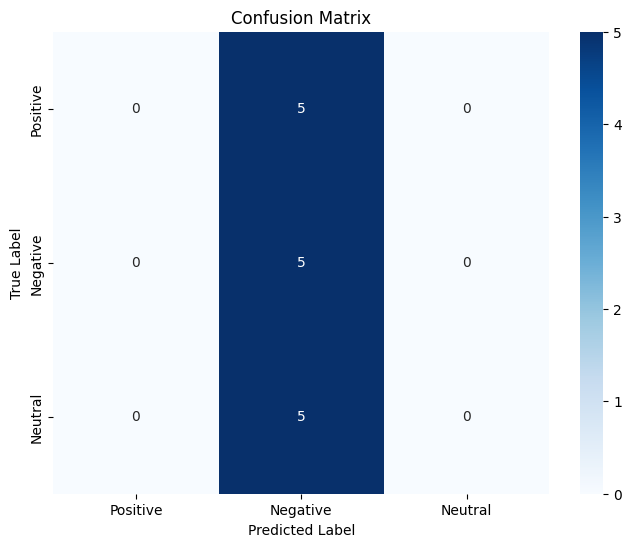

In [15]:
label_names = ['Positive', 'Negative', 'Neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
print("\nPer-class metrics:")
print("-" * 50)

for class_idx in range(3):
    tp = confusion_matrix_values[class_idx][class_idx]

    fp = 0
    for i in range(3):
        if i != class_idx:
            fp += confusion_matrix_values[i][class_idx]

    fn = 0
    for j in range(3):
        if j != class_idx:
            fn += confusion_matrix_values[class_idx][j]

    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    print(f"\n{label_names[class_idx]}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")



Per-class metrics:
--------------------------------------------------

Positive:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Negative:
  Precision: 0.3333
  Recall: 1.0000
  F1-Score: 0.5000

Neutral:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


In [17]:
test_sentences = [
    "Tech company announces breakthrough, stock jumps 12%",
    "Global recession fears cause market crash",
    "Company maintains steady growth as expected"
]

print("\nTesting on new examples:")
print("-" * 50)

for sentence in test_sentences:
    inputs = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=-1)

        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = torch.max(probs).item()

    print(f"\nText: {sentence}")
    print(f"Predicted class: {label_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")

    print("All probabilities:")
    print(f"  Positive: {probs[0][0].item():.4f}")
    print(f"  Negative: {probs[0][1].item():.4f}")
    print(f"  Neutral: {probs[0][2].item():.4f}")


Testing on new examples:
--------------------------------------------------

Text: Tech company announces breakthrough, stock jumps 12%
Predicted class: Negative
Confidence: 0.4195
All probabilities:
  Positive: 0.3352
  Negative: 0.4195
  Neutral: 0.2453

Text: Global recession fears cause market crash
Predicted class: Positive
Confidence: 0.3487
All probabilities:
  Positive: 0.3487
  Negative: 0.3473
  Neutral: 0.3040

Text: Company maintains steady growth as expected
Predicted class: Negative
Confidence: 0.3991
All probabilities:
  Positive: 0.3612
  Negative: 0.3991
  Neutral: 0.2397


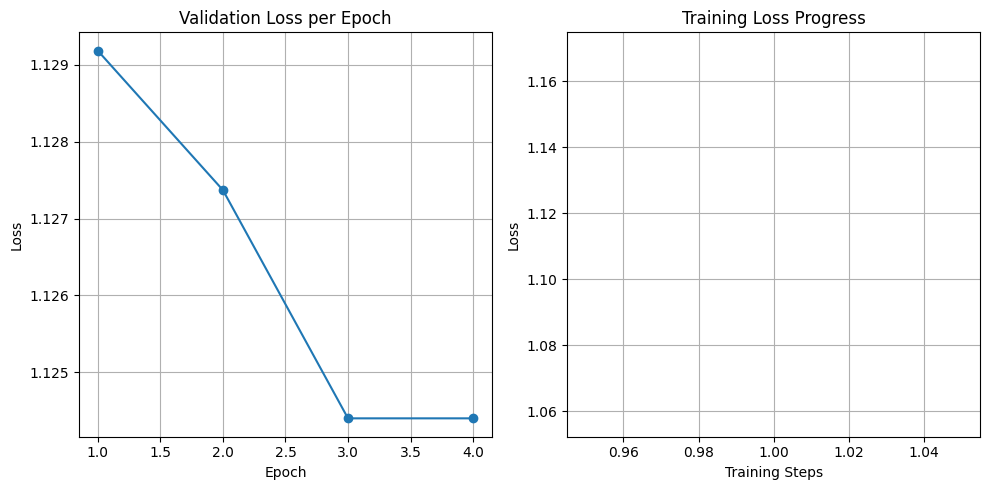

In [18]:
training_loss_history = []
validation_loss_history = []

for log in trainer.state.log_history:
    if 'loss' in log:
        training_loss_history.append(log['loss'])
    if 'eval_loss' in log:
        validation_loss_history.append(log['eval_loss'])

if len(validation_loss_history) > 0:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(validation_loss_history) + 1)
    plt.plot(epochs, validation_loss_history, 'o-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss per Epoch')
    plt.grid(True)

    if len(training_loss_history) > 0:
        plt.subplot(1, 2, 2)
        steps = range(1, len(training_loss_history) + 1)
        plt.plot(steps, training_loss_history, label='Training Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Training Loss Progress')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
model_save_path = './financial_bert_model'

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: ./financial_bert_model


In [20]:
from transformers import BertForSequenceClassification, BertTokenizer

loaded_model = BertForSequenceClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_save_path)

loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")

test_text = "Stock market shows positive momentum"

test_inputs = loaded_tokenizer(
    test_text,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=max_length
)

test_inputs = {k: v.to(device) for k, v in test_inputs.items()}

with torch.no_grad():
    test_outputs = loaded_model(**test_inputs)
    test_logits = test_outputs.logits
    test_probs = torch.softmax(test_logits, dim=-1)
    test_prediction = torch.argmax(test_probs, dim=-1).item()

print(f"\nTest with loaded model:")
print(f"Text: {test_text}")
print(f"Prediction: {label_names[test_prediction]}")

Model loaded successfully

Test with loaded model:
Text: Stock market shows positive momentum
Prediction: Negative


In [21]:
print("\n" + "=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)
print(f"Model: {model_name}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Final validation accuracy: {accuracy:.2%}")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final validation loss: {eval_results['eval_loss']:.4f}")
print("=" * 50)


TRAINING SUMMARY
Model: bert-base-uncased
Training samples: 57
Validation samples: 15
Number of epochs: 3
Batch size: 16
Final validation accuracy: 33.33%
Final training loss: 1.1188
Final validation loss: 1.1244


In [22]:
print("Notebook completed successfully!")

Notebook completed successfully!
